#Miljødataanalyse - Kode Del

In [13]:
import requests
import pandas as pd
import os
from pandasql import sqldf 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import timedelta
import sys
#All import i en celle for ryddighets skyld
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import funksjoner as fj

test = fj.load_data()
print(test.head())

                   time  temperature  humidity  wind_speed  cloud_cover  \
0  2025-05-25T19:00:00Z         13.5      66.1         7.3         84.7   
1  2025-05-25T20:00:00Z         12.6      68.3         7.5         82.1   
2  2025-05-25T21:00:00Z         12.1      69.4         6.8         87.4   
3  2025-05-25T22:00:00Z         12.2      69.5         6.6         94.2   
4  2025-05-25T23:00:00Z         12.4      72.0         7.1         99.8   

   pressure  
0     994.5  
1     994.4  
2     994.4  
3     994.5  
4     994.6  


In [14]:
"""Oppgave 2 Datainnsamling"""
"""
Hentet fra: https://api.met.no/ mer spesifikt hentet jeg API-en fra:
 https://api.met.no/weatherapi/locationforecast/2.0/documentation
"""

df = fj.load_data()

#Bruke pandasql for å finne 10 varmeste tidene (Den sto i oppgaven vi måtte bruke pandasql så jeg bare la noe til, vi kan endre på det senere)
query = "SELECT time, temperature FROM df WHERE temperature IS NOT NULL ORDER BY temperature DESC LIMIT 10"
result = sqldf(query)
print(result)





                   time  temperature
0  2025-06-04T12:00:00Z         18.4
1  2025-05-27T13:00:00Z         17.8
2  2025-06-02T12:00:00Z         17.7
3  2025-05-27T12:00:00Z         17.6
4  2025-05-27T14:00:00Z         17.6
5  2025-06-03T12:00:00Z         17.5
6  2025-06-02T18:00:00Z         17.2
7  2025-06-03T18:00:00Z         17.1
8  2025-05-27T11:00:00Z         17.0
9  2025-06-04T18:00:00Z         17.0


In [15]:
"""Forsøk på å lagre eldre data fra API-en"""

def oppdater_lagringsfil(ny_df, filnavn="../data/lagret_data.csv"): 
    """
    Oppdaterer en lokal CSV-fil med nye API-data og unngår duplikater basert på tid.
    Alle tidspunkter konverteres til samme format (YYYY-MM-DD HH:MM:SS)
    """
    #ny_df: Midlertidig DataFrame med nye værdata
    #filnavn: Navnet og location på nye CSV-filen som lagrer dataene

    #Sørger for at 'time' i ny_df er i datetime-format uten tidssone og med samme strengformat
    ny_df["time"] = pd.to_datetime(ny_df["time"]).dt.tz_convert(None)
    ny_df["time"] = ny_df["time"].dt.strftime("%Y-%m-%d %H:%M:%S")

    #Hvis filen finnes fra før
    if os.path.exists(filnavn):
        eksisterende = pd.read_csv(filnavn)
        #Gjør det samme med eksisterende data
        eksisterende["time"] = pd.to_datetime(eksisterende["time"], errors="coerce")
        eksisterende["time"] = eksisterende["time"].dt.strftime("%Y-%m-%d %H:%M:%S")
        #Kombinerer og fjerner duplikater basert på tidspunkt
        kombinert = pd.concat([eksisterende, ny_df])
        kombinert = kombinert.drop_duplicates(subset="time", keep="last")
    else:
        kombinert = ny_df #Hvis filen ikke finnes, bruker bare den nye dataen
    
    kombinert.to_csv(filnavn, index=False) #Lagrer resultatet tilbake til CSV-filen
    print(f"Lagret {len(kombinert)} rader i '{filnavn}'") #Printer antall rader etter oppdatering
    return kombinert  #Returnerer hele datasettet til videre bruk

df_stor = oppdater_lagringsfil(df) #Dette er datasettet med eldre og nye data

#Lagret 87 rader i '../data/lagret_data.csv' 20.05.2025 klokken 13:00
#Lagret 174 rader i '../data/lagret_data.csv' 20.05.2025 klokken 13:11 (hmmm ser ikke rett ut)
#Lagret 260 rader i '../data/lagret_data.csv' 20.05.2025 klokken 13:26 (huh)
#Slettet og lagde på nytt med konsistent formatering
#Lagret 86 rader i '../data/lagret_data.csv' 20.05.2025 klokken 13:32
#Lagret 172 rader i '../data/lagret_data.csv' 20.05.2025 klokken 13:33 (hmmmmmmmm)
#Slettet igjen og kjørte på nytt med nye endringer
#Lagret 86 rader i '../data/lagret_data.csv' 20.05.2025 klokken 13:44
#Lagret 87 rader i '../data/lagret_data.csv' 20.05.2025 klokken 15:49
#Lagret 92 rader i '../data/lagret_data.csv' 20.05.2025 klokken 18:00

Lagret 213 rader i '../data/lagret_data.csv'


In [16]:
"""Forsøk på å skape manglende verdier"""
df_broken = fj.legg_til_manglende_verdier(df_stor) 

In [17]:
"""Oppgave 3 Databehandling"""

def vis_manglende_verdier(df_broken):
    """Finner og viser manglende verdier per kolonne"""
    manglende = df_broken.isnull().sum()
    total_mangler = manglende.sum()

    if total_mangler == 0:
        print("Det er ingen manglende verdier i datasettet.")
    else:
        print("Manglende verdier per kolonne:")
        print(manglende[manglende > 0])

def prepare_data(df_broken):
    """Kjører alle steg: viser, renser, formaterer og legger til kolonne for kuldegrader"""
    df_broken = fj.rens_data(df_broken)
    df_broken = fj.formater_data(df_broken)
    df_broken = fj.flagg_kuldegrader(df_broken)
    return df_broken


vis_manglende_verdier(df_broken) #før fikset
df_fiks = fj.rens_data(df_broken)
vis_manglende_verdier(df_fiks)  #etter fikset

df_fixed = prepare_data(df_broken)

#Viser 10 nyeste temperaturene med pandasql
query = "SELECT time, temperature FROM df_fixed WHERE temperature IS NOT NULL ORDER BY time DESC LIMIT 10"
result = sqldf(query)
print(result)

Manglende verdier per kolonne:
temperature     6
humidity       16
wind_speed     14
cloud_cover    14
pressure       17
dtype: int64
Det er ingen manglende verdier i datasettet.
                         time  temperature
0  2025-06-04 18:00:00.000000         17.0
1  2025-06-04 12:00:00.000000         18.4
2  2025-06-04 06:00:00.000000         14.1
3  2025-06-04 00:00:00.000000         12.3
4  2025-06-03 18:00:00.000000         17.1
5  2025-06-03 12:00:00.000000         17.5
6  2025-06-03 06:00:00.000000         13.7
7  2025-06-03 00:00:00.000000         12.4
8  2025-06-02 18:00:00.000000         17.2
9  2025-06-02 12:00:00.000000         17.7


In [18]:
"""Oppgave 4 Dataanalyse"""
#Her bruker jeg både NumPy og Pandas for å beregne gjennomsnitt, median og standardavvik.

def vis_statistikk(df_fixed):
    """Finner og viser gjennomsnitt, median og standardavvik for utvalgte variabler"""
    print("Gjennomsnitt:")
    print(df_fixed[["temperature", "humidity", "wind_speed_mps", "cloud_cover", "pressure"]].mean())

    print("\nMedian:")
    print(df_fixed[["temperature", "humidity", "wind_speed_mps", "cloud_cover", "pressure"]].median())

    print("\nStandardavvik:")
    print(df_fixed[["temperature", "humidity", "wind_speed_mps", "cloud_cover", "pressure"]].std())

def analyse_temperaturfordeling(df_fixed):
    """Bruker NumPy til å finne gjennomsnittlig fordeling av temperaturverdier"""
    datas = df_fixed["temperature"].dropna().values
    mean = np.mean(datas)
    median = np.median(datas)
    std = np.std(datas)

    print("\nGjennomsnittlig temperaturfordeling:")
    print(f" - Gjennomsnitt temperatur: {mean:.2f}°C")
    print(f" - Median: {median:.2f}°C")
    print(f" - Standardavvik: {std:.2f}°C")

    if mean > median:
        print(" - Det er flere lave temperaurer")
    elif mean < median:
        print(" - Det er flere varme temperaturer")
    else:
        print(" - Temperaturfordelingen er gjevn")

vis_statistikk(df_fixed)

analyse_temperaturfordeling(df_fixed)

#Lineær regjresjonsanalyse her kanskje?

#Viser mønster at temperaturen er konsekvent lavere om natten :)
def analyser_dagstemperatur(df_fixed):
    """Sammenligner gjennomsnittstemperatur mellom natt (20:00–06:00) og dag (07:00–19:00)"""
    df_fixed = df_fixed.copy() #Lager kopi
    df_fixed["hour"] = df_fixed["time"].dt.hour  # Henter timeverdi fra tid 

    def natt_eller_dag(hour):
        """Klassifiserer hva som er natt og dag"""
        return "Natt:" if (hour >= 20 or hour <= 6) else "Dag:"
    
    #Går gjennom timene og klassifiserer dag eller natt og lager en ny kolonne "Tidspunkt" med dag og natt 
    df_fixed["Tidspunkt"] = df_fixed["hour"].apply(natt_eller_dag) 

    #Grupperer dag og natt radene og finner gjennomsnitt for natt og dag
    gjennomsnitt = df_fixed.groupby("Tidspunkt")["temperature"].mean()


    #Printer resultatene
    print("\nGjennomsnittstemperaturer:")
    print(gjennomsnitt)
    
    #Finner og printer den gjennomsnittlige differansen på dag og natt
    diff = gjennomsnitt["Dag:"] - gjennomsnitt["Natt:"]
    print(f"\nDifferanse dag og natt: {diff:.2f} °C")
    
    return gjennomsnitt

analyser_dagstemperatur(df_fixed)

Gjennomsnitt:
temperature         10.013615
humidity            75.169014
wind_speed_mps       3.611737
cloud_cover         80.012060
pressure          1006.086224
dtype: float64

Median:
temperature          9.700000
humidity            75.000000
wind_speed_mps       3.600000
cloud_cover         88.200000
pressure          1006.086224
dtype: float64

Standardavvik:
temperature        3.247024
humidity          12.946901
wind_speed_mps     1.712800
cloud_cover       25.243493
pressure           6.974161
dtype: float64

Gjennomsnittlig temperaturfordeling:
 - Gjennomsnitt temperatur: 10.01°C
 - Median: 9.70°C
 - Standardavvik: 3.24°C
 - Det er flere lave temperaurer

Gjennomsnittstemperaturer:
Tidspunkt
Dag:     11.263793
Natt:     8.518557
Name: temperature, dtype: float64

Differanse dag og natt: 2.75 °C


Tidspunkt
Dag:     11.263793
Natt:     8.518557
Name: temperature, dtype: float64

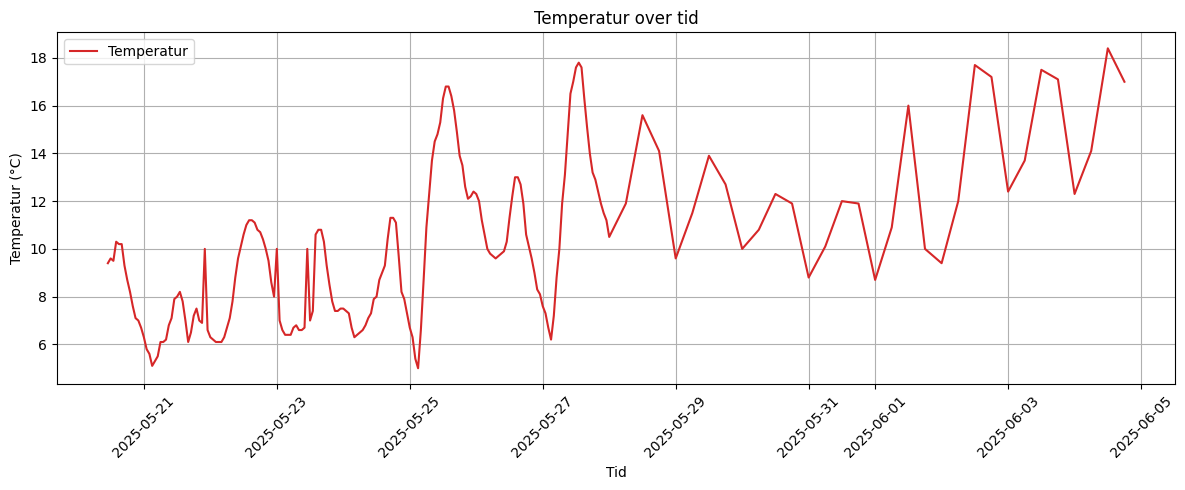


Gjennomsnittstemperaturer:
Tidspunkt
Dag:     11.263793
Natt:     8.518557
Name: temperature, dtype: float64

Differanse dag og natt: 2.75 °C


C:\Users\betja\AppData\Local\Temp\ipykernel_18448\1473777533.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gjennomsnitt.index, y=gjennomsnitt.values, palette="coolwarm")


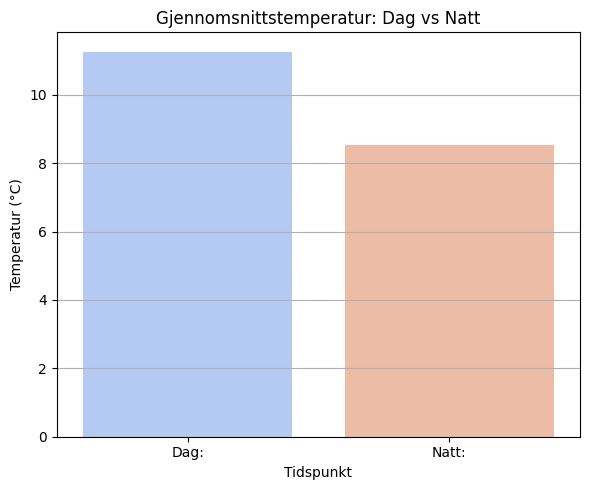

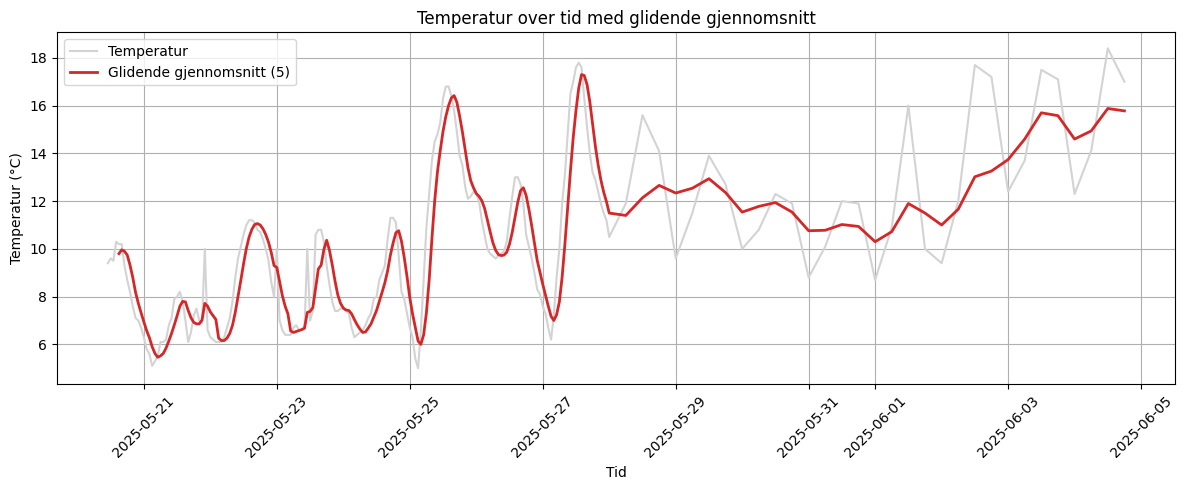

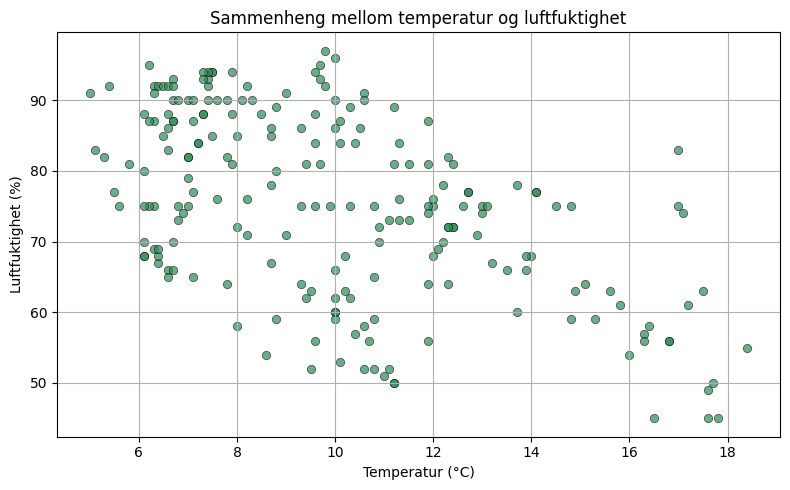

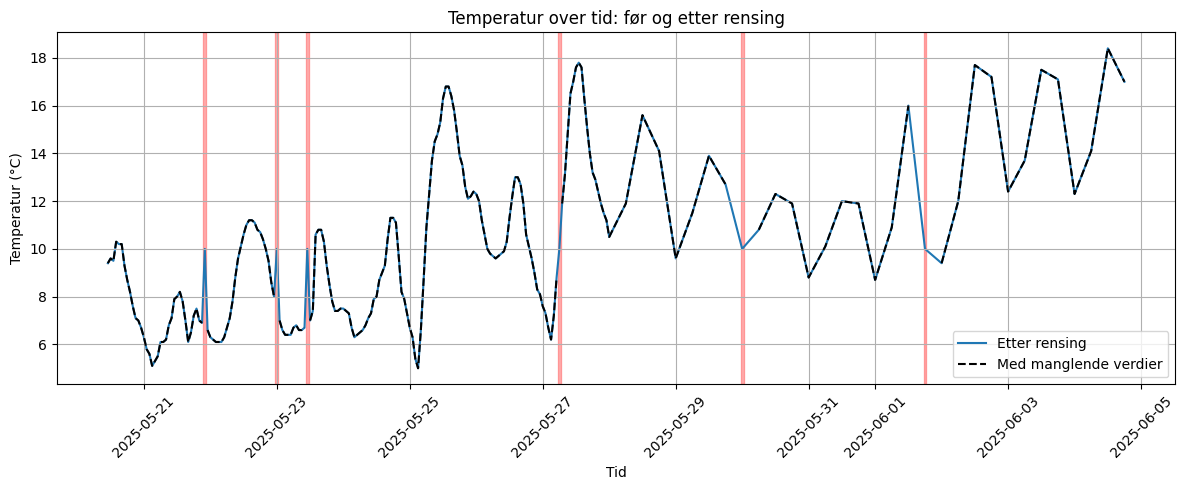

In [19]:
"""Oppgave 5: Visualisering"""

def temp_over_tid_plot(df_fixed):
    """Lager en linjegraf av temperaturen over tid"""
    plt.figure(figsize=(12, 5)) #Størrelse på figuren
    plt.plot(df_fixed["time"], df_fixed["temperature"], color="tab:red", label="Temperatur") #Plotter temp mot tid
    plt.title("Temperatur over tid") #Tittel på grafen
    plt.xlabel("Tid") #X-akse tittel
    plt.ylabel("Temperatur (°C)") #Y-akse tittel
    plt.xticks(rotation=45) #Roterer tidsetiketter for bedre lesbarhet
    plt.legend() #Viser etikett
    plt.grid(True) #Viser rutenett
    plt.tight_layout() #Hindrer overlapp
    plt.show()
#Et linjediagram er ideelt for å vise trender over tid. 
#Her ser vi tydelig hvordan temperaturen endrer seg time for time over flere dager.

temp_over_tid_plot(df_fixed)

def dag_vs_natt_plot(df_fixed):
    """Lager en søylediagram av gjennomsnittstemperatur for dag og natt"""
    gjennomsnitt = analyser_dagstemperatur(df_fixed) #Bruker funksjonen fra oppgave 4

    plt.figure(figsize=(6, 5))
    sns.barplot(x=gjennomsnitt.index, y=gjennomsnitt.values, palette="coolwarm")
    plt.title("Gjennomsnittstemperatur: Dag vs Natt")
    plt.ylabel("Temperatur (°C)")
    plt.xlabel("Tidspunkt")
    plt.grid(axis="y") #Rutenett på Y-aksen
    plt.tight_layout()
    plt.show()
#Et søylediagram er effektivt for å sammenligne gjennomsnitt. 
#Denne viser fint forskjellen på dag og natt

dag_vs_natt_plot(df_fixed)

def temp_med_glidende_snitt(df_fixed, vindu=5):
    """Temperatur over tid med glidende gjennomsnitt"""
    plt.figure(figsize=(12, 5))
    plt.plot(df_fixed["time"], df_fixed["temperature"], color="lightgray", label="Temperatur") #Originaldata
    plt.plot(df_fixed["time"], df_fixed["temperature"].rolling(vindu).mean(), color="tab:red", linewidth=2, label=f"Glidende gjennomsnitt ({vindu})")
    plt.title("Temperatur over tid med glidende gjennomsnitt")
    plt.xlabel("Tid")
    plt.ylabel("Temperatur (°C)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
#Det glidende gjennomsnittet jevner ut temperaturvariasjonene,
#slik at trenden over tid blir lettere å tolke visuelt

temp_med_glidende_snitt(df_fixed)

def scatter_temp_vs_fuktighet(df_fixed):
    """Lager et scatterplot for å vise forholdet mellom temperatur og luftfuktighet"""
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=df_fixed,
        x="temperature",
        y="humidity",
        color="seagreen",  #Velger ønsket farge
        edgecolor="black",  #Gir punktene en kontrastkant
        alpha=0.7  #Gjør punktene litt gjennomsiktige for bedre oversikt
    )
    plt.title("Sammenheng mellom temperatur og luftfuktighet")
    plt.xlabel("Temperatur (°C)")
    plt.ylabel("Luftfuktighet (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
#En scatterplot er nyttig for å identifisere korrelasjoner mellom variabler. 
#Her kan vi se hvordan temperatur og fuktighet henger sammen. 

scatter_temp_vs_fuktighet(df_fixed)

df_broken = fj.formater_data(df_broken) #Sørger for at df_broken kan brukes i visualisering

def vis_manglende_vs_utfylt(df_broken, df_fixed):
    """Sammenligner temperatur over tid med og uten manglende verdier"""
    plt.figure(figsize=(12, 5))
    plt.plot(df_fixed["time"], df_fixed["temperature"], label="Etter rensing", color="tab:blue", zorder=1)
    plt.plot(df_broken["time"], df_broken["temperature"], label="Med manglende verdier", color="black", linestyle="--", zorder=2)
    
    #Finner og fremhever tidsperioder med manglende verdier i originalen
    manglende_tid = df_broken["temperature"].isnull()

    if manglende_tid.any():
        for i in range(len(manglende_tid)):
            if manglende_tid.iloc[i]:
                time = df_broken["time"].iloc[i]
                plt.axvspan(time - pd.Timedelta(minutes=30),
                            time + pd.Timedelta(minutes=30),
                            color='red', alpha=0.3, zorder=0)
    plt.title("Temperatur over tid: før og etter rensing")
    plt.xlabel("Tid")
    plt.ylabel("Temperatur (°C)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
#Denne grafen hjelper oss forstå hvordan manglende verdier kan påvirke visualiseringen.
#Ved å sammenligne renset og urenset datasett, ser vi hullene som røde områder.

vis_manglende_vs_utfylt(df_broken, df_fixed)


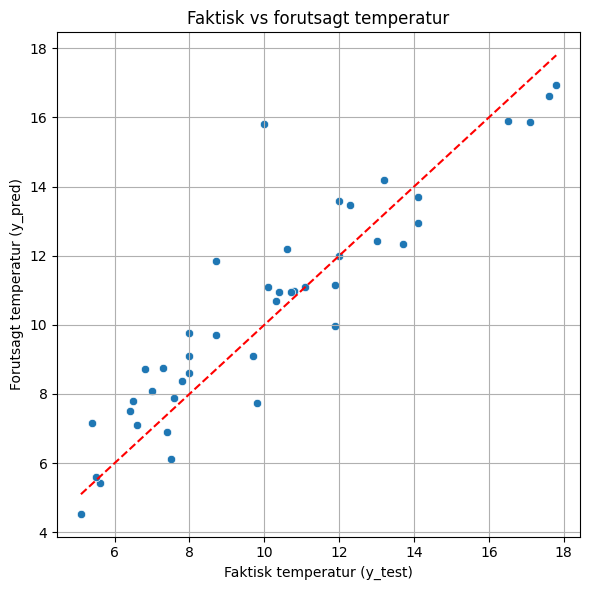

Mean Absolute Error (MAE): 1.08 °C
Dette betyr at gjennomsnittlig er modellens temperaturforutsigelser feil med omtrent 1.08 °C.
Mean Squared Error (MSE): 2.10
Root Mean Squared Error (RMSE): 1.45 °C
R² score: 0.81


C:\Users\betja\AppData\Local\Temp\ipykernel_18448\1414394995.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_times = pd.date_range(start=last_time + timedelta(hours=1), periods=24, freq="H")


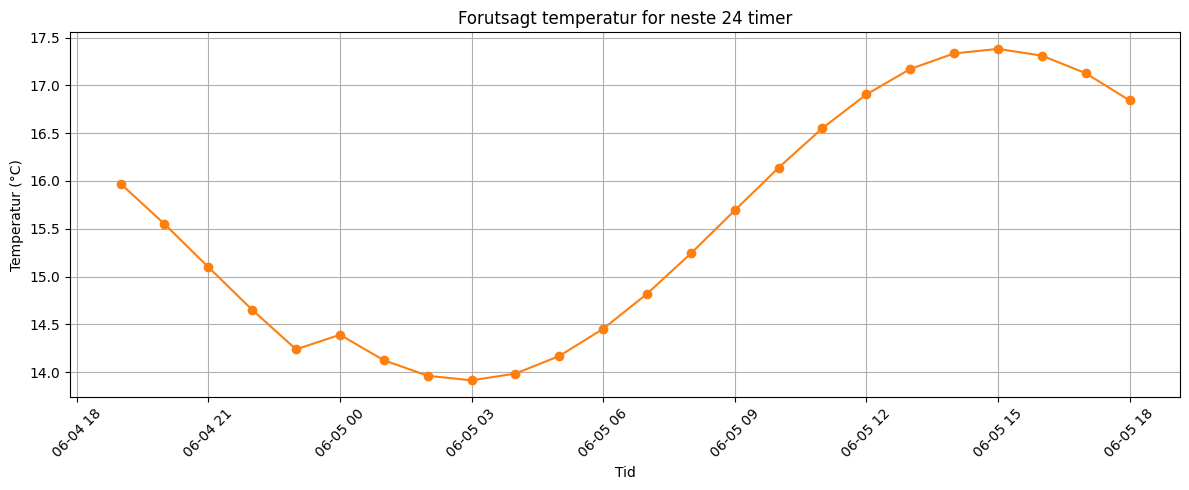

Grafen viser temperaturforutsigelser for de neste 24 timene, basert på en 
lineær regresjonsmodell trent på værdata fra API-en.
Modellen bruker blant annet luftfuktighet, 
skydekke, lufttrykk og klokkeslett som forklaringsvariabler.

Ved å bruke trigonometiske funksjoner (hour_sin og hour_cos) klarer modellen å 
forstå det sykliske mønsteret i temperatur over døgnet,
for eksempel at temperaturen ofte er høyest om ettermiddagen og lavest 
tidlig på morgenen. Figuren viser en naturlig temperaturkurve, hvor temperaturen 
stiger fra morgen til ettermiddag, faller gradvis gjennom kvelden og natten og mot slutten stiger igjen når solen går opp
Dette mønsteret bekrefter at modellen har lært dag/natt-rytmen, og prediksjonene
gir mening i en realistisk kontekst.


In [20]:
"""Oppgave 6: Prediktiv analyse"""

#Legger til tidsbaserte funksjoner (timer og dager)
df_fixed["hour"] = df_fixed["time"].dt.hour
df_fixed["dayofyear"] = df_fixed["time"].dt.dayofyear

#Gjør timen syklisk (for bedre modell)
df_fixed["hour_sin"] = np.sin(2 * np.pi * df_fixed["hour"] / 24)
df_fixed["hour_cos"] = np.cos(2 * np.pi * df_fixed["hour"] / 24)

#Uavhengige variabler (forklaringsvariabler)
X = df_fixed[["humidity", "cloud_cover", "pressure", "hour_sin", "hour_cos", "dayofyear"]]

#Målvariabel (det vi skal forutsi)
y = df_fixed["temperature"]

#Splitter dataene i treningssett og testsett
#Dette gjør at 80% av dataen vil bli brukt til trening og 20% til testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Lager og trener modellen
modell = LinearRegression()
modell.fit(X_train, y_train)

#Lager forutsigelser på testdata
y_pred = modell.predict(X_test)

#Plotter faktisk vs. forutsagt temperatur
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
plt.xlabel("Faktisk temperatur (y_test)")
plt.ylabel("Forutsagt temperatur (y_pred)")
plt.title("Faktisk vs forutsagt temperatur")
plt.grid(True)
plt.tight_layout()
plt.show()

#Gir forutsagte verdier
y_pred = modell.predict(X_test)

#Evaluerer modellens ytelse med ulike feilmål
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

#Printer resultat
print(f"Mean Absolute Error (MAE): {mae:.2f} °C")
print(f"Dette betyr at gjennomsnittlig er modellens temperaturforutsigelser feil med omtrent {mae:.2f} °C.")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} °C")
print(f"R² score: {r2:.2f}")

#Genererer fremtidige tidspunkt (neste 24 timer)
last_time = df_fixed["time"].max()
future_times = pd.date_range(start=last_time + timedelta(hours=1), periods=24, freq="H")

#Lager fremtidig datasett med gjennomsnittlige værverdier
future_df = pd.DataFrame({
    "time": future_times,
    "humidity": df_fixed["humidity"].mean(),
    "wind_speed_mps": df_fixed["wind_speed_mps"].mean(), 
    "cloud_cover": df_fixed["cloud_cover"].mean(),
    "pressure": df_fixed["pressure"].mean()
})

#Legger til sykliske og tidsbaserte variabler
future_df["hour"] = future_df["time"].dt.hour
future_df["dayofyear"] = future_df["time"].dt.dayofyear
future_df["hour_sin"] = np.sin(2 * np.pi * future_df["hour"] / 24)
future_df["hour_cos"] = np.cos(2 * np.pi * future_df["hour"] / 24)

#Velger samme inputkolonner som brukt under trening
future_X = future_df[["humidity", "cloud_cover", "pressure", "hour_sin", "hour_cos", "dayofyear"]]

#Bruker modellen til å forutsi temperatur
future_df["predicted_temperature"] = modell.predict(future_X)

#Visualiserer forutsagte temperaturer
plt.figure(figsize=(12, 5))
plt.plot(future_df["time"], future_df["predicted_temperature"], marker='o', color="tab:orange")
plt.title("Forutsagt temperatur for neste 24 timer")
plt.xlabel("Tid")
plt.ylabel("Temperatur (°C)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
print(
"""Grafen viser temperaturforutsigelser for de neste 24 timene, basert på en 
lineær regresjonsmodell trent på værdata fra API-en.
Modellen bruker blant annet luftfuktighet, 
skydekke, lufttrykk og klokkeslett som forklaringsvariabler.
\nVed å bruke trigonometiske funksjoner (hour_sin og hour_cos) klarer modellen å 
forstå det sykliske mønsteret i temperatur over døgnet,
for eksempel at temperaturen ofte er høyest om ettermiddagen og lavest 
tidlig på morgenen. Figuren viser en naturlig temperaturkurve, hvor temperaturen 
stiger fra morgen til ettermiddag, faller gradvis gjennom kvelden og natten og mot slutten stiger igjen når solen går opp
Dette mønsteret bekrefter at modellen har lært dag/natt-rytmen, og prediksjonene
gir mening i en realistisk kontekst."""
)